# Project: Semantic similarity extraction using word vectors in Harry Potter dataset

## Exploring the Data
Run the code cell below to load necessary Python libraries.

In [1]:
#future is the missing compatibility layer between Python 2 and Python 3. 
#It allows you to use a single, clean Python 3.x-compatible codebase to 
#support both Python 2 and Python 3 with minimal overhead.
from __future__ import absolute_import, division, print_function

In [2]:
#word encoding
import codecs
#finds all pathnames matching a pattern, like regex
import glob
#log events for libraries
import logging
#concurrency
import multiprocessing
#dealing with operating system
import os
#pretty print, human readable
import pprint
#regular expressions
import re
#natural language toolkit
import nltk
#word 2 vec   (conda install -c anaconda gensim=1.0.1)
import gensim.models.word2vec as w2v
#dimensionality reduction
import sklearn.manifold
#math
import numpy as np
#plotting
import matplotlib.pyplot as plt
#parse dataset
import pandas as pd
#visualization
import seaborn as sns

I:\Anaconda\lib\site-packages\gensim\utils.py:855: UserWarning: detected Windows; aliasing chunkize to chunkize_serial
  warnings.warn("detected Windows; aliasing chunkize to chunkize_serial")


In [3]:
%pylab inline

Populating the interactive namespace from numpy and matplotlib


### Set up logging

In [4]:
logging.basicConfig(format='%(asctime)s : %(levelname)s : %(message)s', level=logging.INFO)

## Download NLTK tokenizer models (only the first time)

In [5]:
##stopwords like the at a an, unnecesasry
##tokenization into sentences, punkt 
##http://www.nltk.org/

nltk.download("punkt")
nltk.download("stopwords")

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\DTILAK\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\DTILAK\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

## Preparing Corpus
### Load book

In [34]:
#get the book names, matching txt file
book_filenames = sorted(glob.glob("..\HP_Sorcerers_Stone_NLP\input\*.txt"))
print("Found book:")
book_filenames

Found book:


["..\\HP_Sorcerers_Stone_NLP\\input\\Harry Potter and the Sorcerer's Stone.txt"]

### Combine the book into one string

In [35]:
#initialize raw unicode , we'll add all text to this file in memory
corpus_raw = u""

#for each book, read it, open it in utf 8 format, 
#add it to the raw corpus
for book_filename in book_filenames:
    print("Reading '{0}'...".format(book_filename))
    with codecs.open(book_filename, "r", "utf-8") as book_file:
        corpus_raw += book_file.read()
    print ("Corpus is now {0} characters long".format(len(corpus_raw)))
    print ()

Reading '..\HP_Sorcerers_Stone_NLP\input\Harry Potter and the Sorcerer's Stone.txt'...
Corpus is now 438189 characters long



### Split the corpus into sentences

In [36]:
#tokenizastion
tokenizer = nltk.data.load('tokenizers/punkt/english.pickle')

#tokenize into sentences
raw_sentences = tokenizer.tokenize(corpus_raw)

In [37]:
#convert into a list of words
#remove unnnecessary, split into words, no hyphens
#list of words
def sentence_to_wordlist(raw):
    clean = re.sub("[^a-zA-Z]"," ", raw)
    words = clean.split()
    return words

In [38]:
#sentence where each word is tokenized
sentences = []
for raw_sentence in raw_sentences:
    if len(raw_sentence) > 0:
        sentences.append(sentence_to_wordlist(raw_sentence))

In [39]:
# Example
print(raw_sentences[5])
print(sentence_to_wordlist(raw_sentences[5]))

The Dursleys had a small son called Dudley and in their
opinion there was no finer boy anywhere.
[u'The', u'Dursleys', u'had', u'a', u'small', u'son', u'called', u'Dudley', u'and', u'in', u'their', u'opinion', u'there', u'was', u'no', u'finer', u'boy', u'anywhere']


In [40]:
token_count = sum([len(sentence) for sentence in sentences])
print("The book corpus contains {0:,} tokens.".format(token_count))

The book corpus contains 80,640 tokens.


### Build word2vec model

In [41]:
# Dimensionality of the resulting word vectors.
# more dimensions, more computationally expensive to train
# but also more accurate
# more dimensions = more generalized
num_features = 300

# Minimum word count threshold.
min_word_count = 3

# Number of threads to run in parallel.
# more workers, faster we train
num_workers = multiprocessing.cpu_count()

# Context window length.
context_size = 7

# Downsample setting for frequent words.
# 0 - 1e-5 is good for this
downsampling = 1e-3

# Seed for the random number generator, to make the results reproducible.
seed = 1

In [42]:
HP2vec = w2v.Word2Vec(
    sg=1,
    seed=seed,
    workers=num_workers,
    size=num_features,
    min_count=min_word_count,
    window=context_size,
    sample=downsampling
)

In [43]:
HP2vec.build_vocab(sentences)

2017-04-08 14:20:32,457 : INFO : collecting all words and their counts
2017-04-08 14:20:32,457 : INFO : PROGRESS: at sentence #0, processed 0 words, keeping 0 word types
2017-04-08 14:20:32,489 : INFO : collected 6651 word types from a corpus of 80640 raw words and 6394 sentences
2017-04-08 14:20:32,490 : INFO : Loading a fresh vocabulary
2017-04-08 14:20:32,510 : INFO : min_count=3 retains 2675 unique words (40% of original 6651, drops 3976)
2017-04-08 14:20:32,513 : INFO : min_count=3 leaves 75676 word corpus (93% of original 80640, drops 4964)
2017-04-08 14:20:32,528 : INFO : deleting the raw counts dictionary of 6651 items
2017-04-08 14:20:32,529 : INFO : sample=0.001 downsamples 54 most-common words
2017-04-08 14:20:32,530 : INFO : downsampling leaves estimated 56964 word corpus (75.3% of prior 75676)
2017-04-08 14:20:32,532 : INFO : estimated required memory for 2675 words and 300 dimensions: 7757500 bytes
2017-04-08 14:20:32,546 : INFO : resetting layer weights


In [44]:
print("Word2Vec vocabulary length:", len(HP2vec.wv.vocab))

Word2Vec vocabulary length: 2675


### word2vec training, this might take a minute

In [45]:
HP2vec.train(sentences)

2017-04-08 14:20:36,594 : INFO : training model with 4 workers on 2675 vocabulary and 300 features, using sg=1 hs=0 sample=0.001 negative=5 window=7
2017-04-08 14:20:36,594 : INFO : expecting 6394 sentences, matching count from corpus used for vocabulary survey
2017-04-08 14:20:37,668 : INFO : PROGRESS: at 66.76% examples, 188123 words/s, in_qsize 7, out_qsize 0
2017-04-08 14:20:38,158 : INFO : worker thread finished; awaiting finish of 3 more threads
2017-04-08 14:20:38,171 : INFO : worker thread finished; awaiting finish of 2 more threads
2017-04-08 14:20:38,216 : INFO : worker thread finished; awaiting finish of 1 more threads
2017-04-08 14:20:38,247 : INFO : worker thread finished; awaiting finish of 0 more threads
2017-04-08 14:20:38,250 : INFO : training on 403200 raw words (284715 effective words) took 1.6s, 173809 effective words/s


284715

### Save to file, can be useful later

In [46]:
if not os.path.exists("trained"):
    os.makedirs("trained")

In [47]:
HP2vec.save(os.path.join("trained", "HP2vec.w2v"))

2017-04-08 14:20:48,760 : INFO : saving Word2Vec object under trained\HP2vec.w2v, separately None
2017-04-08 14:20:48,776 : INFO : not storing attribute syn0norm
2017-04-08 14:20:48,776 : INFO : not storing attribute cum_table
2017-04-08 14:20:48,832 : INFO : saved trained\HP2vec.w2v


In [48]:
HP2vec = w2v.Word2Vec.load(os.path.join("trained", "HP2vec.w2v"))

2017-04-08 14:20:49,421 : INFO : loading Word2Vec object from trained\HP2vec.w2v
2017-04-08 14:20:49,437 : INFO : loading wv recursively from trained\HP2vec.w2v.wv.* with mmap=None
2017-04-08 14:20:49,437 : INFO : setting ignored attribute syn0norm to None
2017-04-08 14:20:49,437 : INFO : setting ignored attribute cum_table to None
2017-04-08 14:20:49,437 : INFO : loaded trained\HP2vec.w2v


### Compress the word vectors into 3D space using t-SNE and plot them for further analysis

In [49]:
tsne = sklearn.manifold.TSNE(n_components=3,perplexity=15.0, n_iter=20000,random_state=0)

In [50]:
all_word_vectors_matrix = HP2vec.wv.syn0

In [51]:
import gc
gc.collect()

3900

### Train t-SNE, this could take few minute...

In [52]:
all_word_vectors_matrix_3d = tsne.fit_transform(all_word_vectors_matrix)

### Scatter plot

In [53]:
points = pd.DataFrame(
    [
        (word, coords[0], coords[1], coords[2])
        for word, coords in [
            (word, all_word_vectors_matrix_3d[HP2vec.wv.vocab[word].index])
            for word in HP2vec.wv.vocab
        ]
    ],
    columns=["word", "x", "y", "z"]
)

In [54]:
if not os.path.exists("points_output"):
    os.makedirs("points_output")
points.to_csv(os.path.join("points_output", "points_threeD.csv"), sep=',')

In [55]:
points.head(10)

,word,x,y,z
0,hats,-9.973680,5.095116,4.114081
1,all,6.524491,-7.604452,-3.119933
2,foul,3.400911,10.351165,17.361861
3,four,-15.901216,5.993733,-17.020745
4,sleep,-4.010988,-9.707311,1.692120
5,hanging,6.697605,11.896030,-4.850712
6,oldest,-5.793925,0.662435,0.931311
7,saved,13.247995,2.468639,-6.073413
8,whose,-12.431085,3.071640,-6.082911
9,Flavor,-4.545277,1.898875,16.834793


In [56]:
sns.set_context("poster")

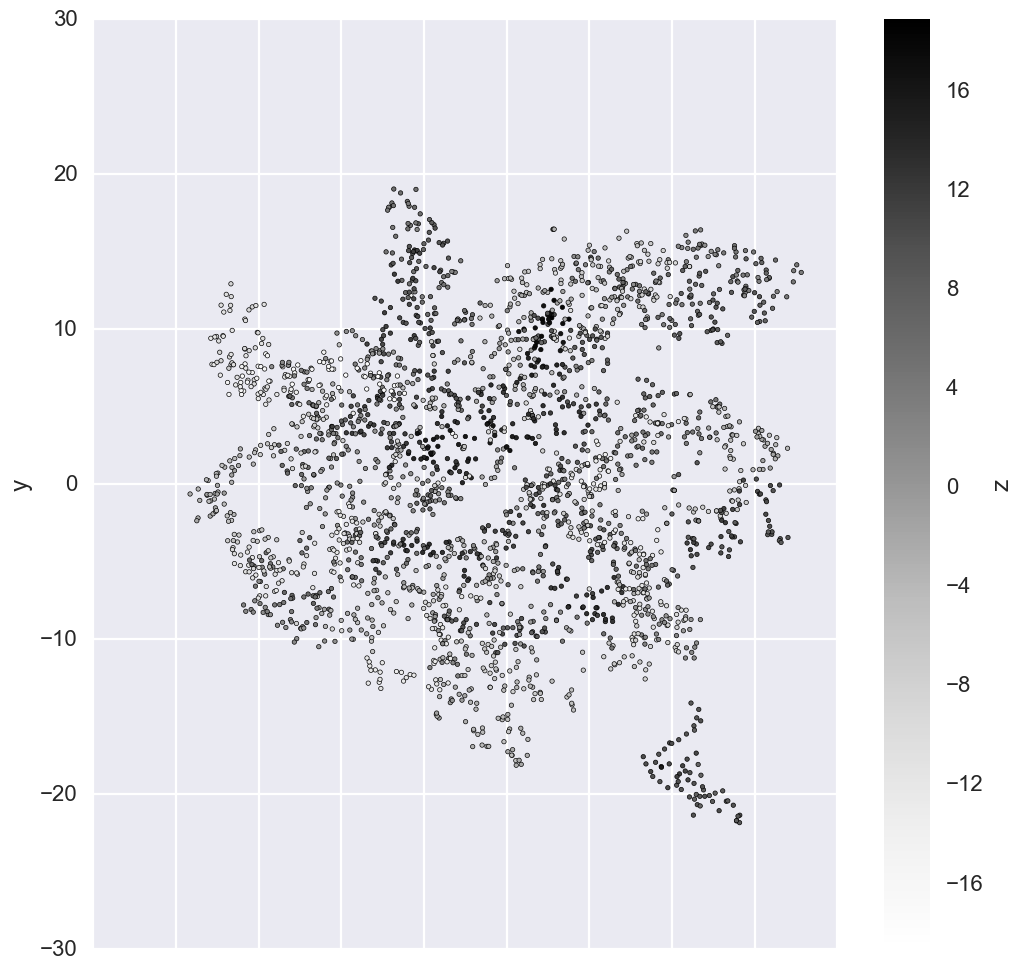

In [57]:
points.plot.scatter("x", "y", c = "z",s=10, figsize=(12, 12))

## Proper noun extraction, to get a good picture of all the characters in the book

In [58]:
all_words = points.word
all_words_df = pd.DataFrame(all_words)
all_words_list = all_words_df['word'].values.tolist()
str_words = ' '.join(all_words_list)
#str_words

In [59]:
essays = str_words
tokens = nltk.word_tokenize(essays)
tagged = nltk.pos_tag(tokens)
nouns = [word for word,pos in tagged if (pos == 'NNP') or (pos == 'NNPS')]
print ("Number of nouns is {}.".format(len(nouns)))

#join into a string
joined = "\n".join(nouns).encode('utf-8')
into_string = str(nouns)

#write in an csv file
#output = open("Proper_noun.csv", "w")
#output.write(joined)
#output.close()

#print as a table
noun_string = " ".join(nouns).encode('utf-8')
nouns_df = pd.DataFrame(nouns)
nouns_df.head(10)

Number of nouns is 363.


,0
0,Flavor
1,Thomas
2,Go
3,Weasley
4,Algie
5,Put
6,Neville
7,NOT
8,Spells
9,Three


(-0.5, 1439.5, 1079.5, -0.5)

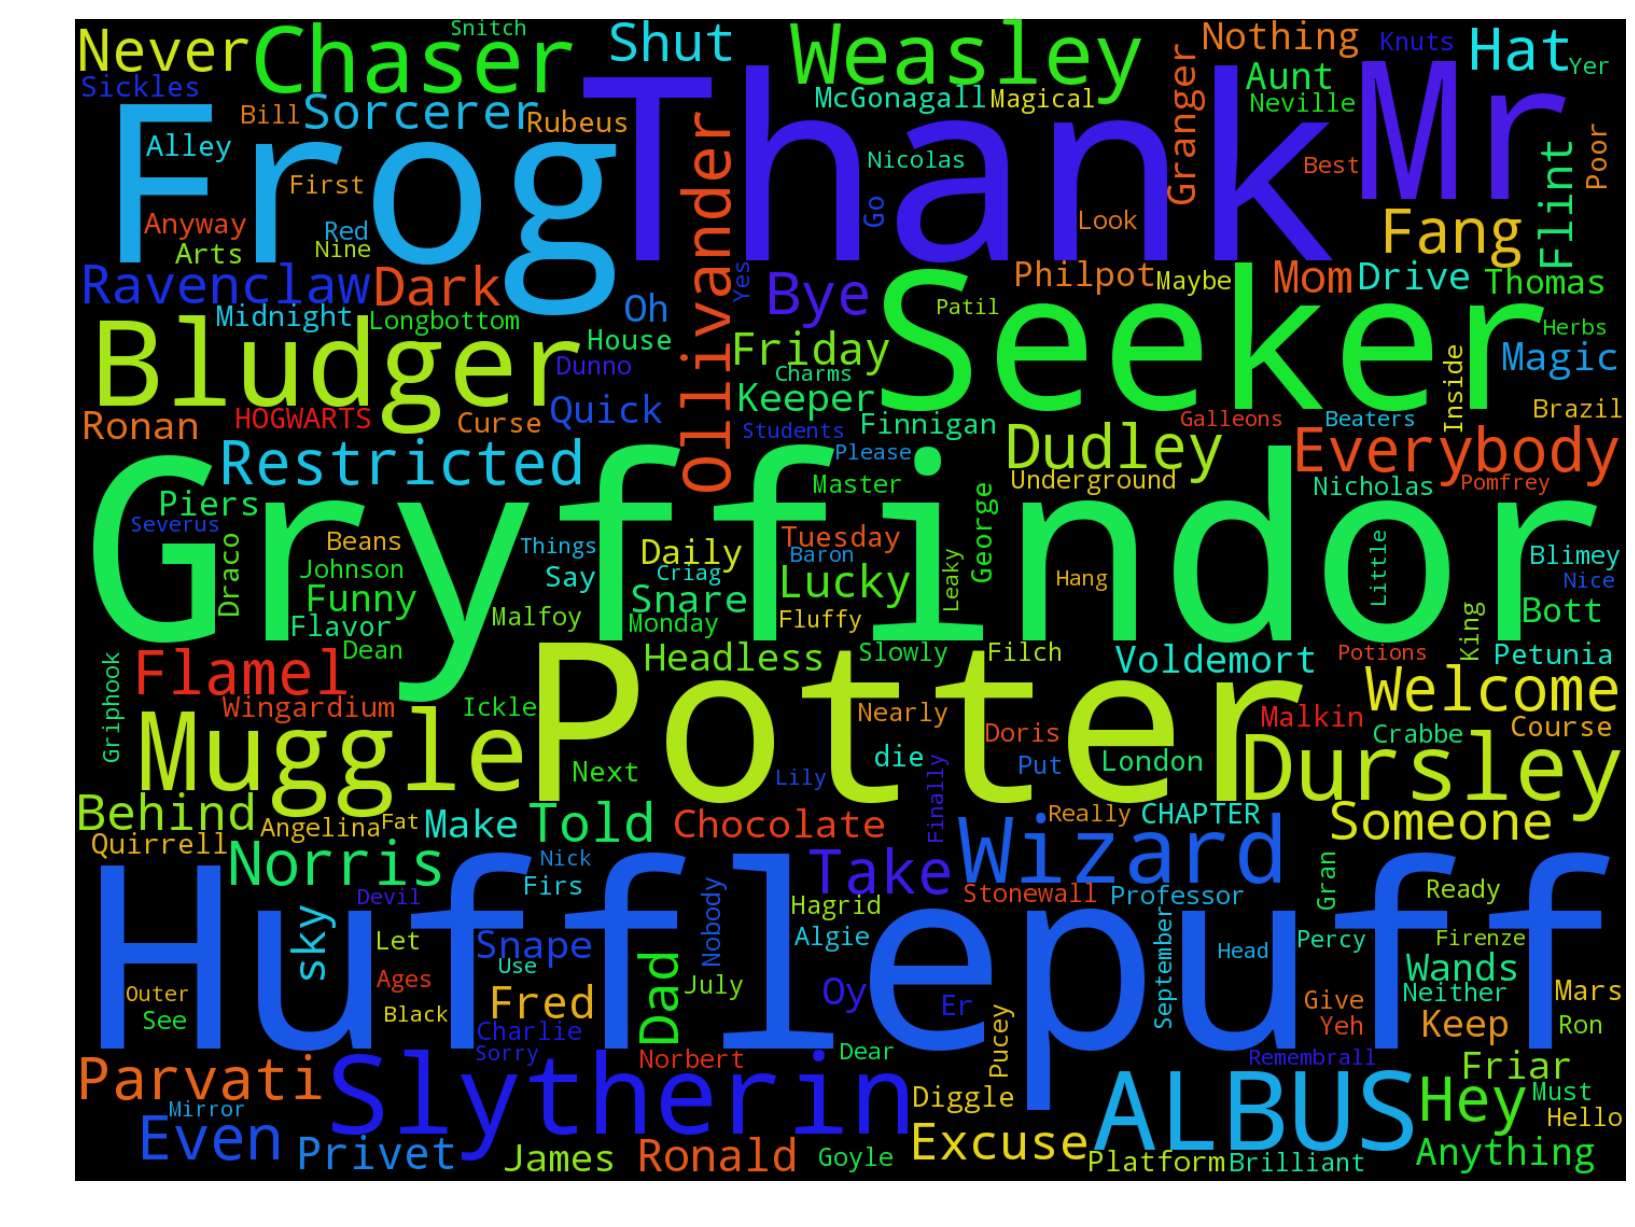

In [60]:
#conda install -c conda-forge wordcloud=1.2.1
from wordcloud import WordCloud
cloud = WordCloud(width=1440, height=1080).generate(noun_string)
plt.figure(figsize=(20, 15))
plt.imshow(cloud)
plt.axis('off')